In [47]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
import json

kaggle_creds = {"username": "maria303","key": "3e509e67e40b697ccdd34ecf8762dc0b"}

# Сохраняем в файл
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_creds, f)

!chmod 600 ~/.kaggle/kaggle.json

print("\nДатасеты:")
!kaggle datasets list --mine

# Имя датасета
dataset_name = "maria303/dl-lab-1-image-classification"
print(f"\nСкачиваем {dataset_name}")

# Скачиваем датасет
!kaggle datasets download -d {dataset_name} --force

import os
import glob
zip_files = glob.glob("*.zip")
print(f"\nНайдены zip файлы: {zip_files}")

if zip_files:
    zip_file = zip_files[0]
    print(f"Разархивируем {zip_file}...")
    !unzip -o -q "{zip_file}" -d ./my_dataset

    # Устанавливаем path точно так же, как в оригинальном коде
    path = "./my_dataset"
    print(f"Путь к данным: {path}")

    # Сохраняем path в переменную окружения, чтобы была доступна в других ячейках
    %store path

    # Проверяем структуру для оригинального кода
    data_folder = os.path.join(path, 'dl-lab-1-image-classification — наш')
    print(f"\nПроверка структуры для ячейки 6:")
    print(f"Содержимое data_folder: {os.listdir(data_folder)}")

    # Проверяем путь, который будет использован в ячейке 6
    dataset_path = os.path.join(data_folder, 'train', 'train')
    print(f"Путь: {dataset_path}")
    print(f"Существует: {os.path.exists(dataset_path)}")

    if os.path.exists(dataset_path):
        print("Готово")
    else:
        print("Путь не существует, проверьте структуру")
else:
    print("Zip файл не найден")


Датасеты:
ref                                       title                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------  ---------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
maria303/dl-lab-1-image-classification    dl-lab-1-image-classification-new   203919330  2026-02-17 18:10:38.620000            109          0  0.11764706       
maria303/dl-lab-1-image-classification-7  dl-lab-1-image-classification-7     201706593  2026-02-26 15:36:33.610000              0          0  0.11764706       

Скачиваем maria303/dl-lab-1-image-classification
Dataset URL: https://www.kaggle.com/datasets/maria303/dl-lab-1-image-classification
License(s): unknown
 57% 111M/194M [00:00<00:00, 1.16GB/s]
100% 194M/194M [00:00<00:00, 794MB/s] 

Найдены zip файлы: ['dl-lab-1-image-classification.zip']
Разархивируем dl-lab-1-image-classification.zip...
Путь

In [16]:
import albumentations as A
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import timm
import os
import random
from collections import defaultdict
from glob import glob

In [17]:
# фиксация всех сидов
SEED = 9999

import os
os.environ["PYTHONHASHSEED"] = str(SEED)

random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# для скорости и качества
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

In [18]:
# заготовка под data loader

def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)


In [19]:
class_to_idx = { "Апельсин": 0, "Бананы": 1, "Груши": 2, "Кабачки": 3, "Капуста": 4, "Картофель": 5, "Киви": 6, "Лимон": 7, "Лук": 8, "Мандарины": 9, "Морковь": 10, "Огурцы": 11, "Томаты": 12, "Яблоки зелёные": 13, "Яблоки красные": 14 }

In [20]:
class MyDataset(Dataset):
    def __init__(self, images_filepaths, name2label, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform
        self.name2label = name2label

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]

        # читаем изображение безопасно: всегда 3 канала (BGR)
        data = np.fromfile(image_filepath, dtype=np.uint8)
        image = cv2.imdecode(data, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # класс = папка на 2 уровня выше: .../Класс/Подкласс/файл.jpg
        class_name = os.path.basename(os.path.dirname(os.path.dirname(image_filepath)))
        label = self.name2label[class_name]

        if self.transform is not None:
            image = self.transform(image=image)['image']

        return image, label


def train_test_split_from_directory(root_path, folder2class=None, train_size=0.8, seed=9999):
    train, test = [], []
    rng = random.Random(seed)

    # Проходим по основным классам (сортируем для воспроизводимости)
    for class_name in sorted(os.listdir(root_path)):
        class_path = os.path.join(root_path, class_name)
        if not os.path.isdir(class_path):
            continue

        # Проходим по подклассам (сортируем для воспроизводимости)
        for subclass_name in sorted(os.listdir(class_path)):
            subclass_path = os.path.join(class_path, subclass_name)
            if not os.path.isdir(subclass_path):
                continue

            # Собираем изображения
            images = (
                glob(os.path.join(subclass_path, '*.jpg')) +
                glob(os.path.join(subclass_path, '*.png')) +
                glob(os.path.join(subclass_path, '*.jpeg'))
            )

            if len(images) == 0:
                continue

            # Перемешиваем изображения в подклассе (локальный rng)
            rng.shuffle(images)

            # Разбиение для каждого подкласса отдельно
            split_idx = int(train_size * len(images))
            train.extend(images[:split_idx])
            test.extend(images[split_idx:])

    return train, test


In [21]:
%store -r path
data_folder = os.path.join(path, 'dl-lab-1-image-classification — наш')
dataset_path = os.path.join(data_folder, 'train', 'train')

train, test = train_test_split_from_directory(
    root_path=dataset_path,
    train_size=0.8,
    seed=SEED
)

print(f"Тренировочных: {len(train)}, Тестовых: {len(test)}")


Тренировочных: 7868, Тестовых: 1991


# Посмотрим на распределение данных

In [22]:
from collections import Counter
import os

def count_classes(image_paths, class_to_idx):
    counts = Counter()
    for image_path in image_paths:
        # класс = папка на 2 уровня выше
        class_name = os.path.basename(
            os.path.dirname(
                os.path.dirname(image_path)
            )
        )
        class_idx = class_to_idx[class_name]
        counts[class_idx] += 1
    return counts


train_counts = count_classes(train, class_to_idx)
test_counts  = count_classes(test, class_to_idx)

print("Train distribution:", train_counts)
print("Test distribution:", test_counts)

Train distribution: Counter({0: 691, 13: 670, 4: 667, 1: 642, 5: 631, 9: 627, 12: 609, 14: 574, 7: 544, 8: 530, 10: 496, 11: 476, 2: 324, 3: 237, 6: 150})
Test distribution: Counter({0: 175, 13: 172, 4: 169, 1: 162, 5: 160, 9: 159, 12: 153, 14: 147, 7: 136, 8: 135, 10: 124, 11: 119, 2: 82, 3: 60, 6: 38})


In [23]:
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(class_to_idx)

# собираем количество примеров по порядку классов 0..14
class_counts = np.array([train_counts[i] for i in range(num_classes)])

# веса обратно пропорциональны количеству
class_weights = 1.0 / class_counts

# нормализация (чтобы средний вес был ≈1)
class_weights = class_weights * (num_classes / class_weights.sum())

class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

print("Class weights:", class_weights)


Class weights: tensor([0.6315, 0.6797, 1.3468, 1.8412, 0.6542, 0.6915, 2.9091, 0.8021, 0.8233,
        0.6960, 0.8798, 0.9167, 0.7165, 0.6513, 0.7602], device='cuda:0')


loss_fn

In [24]:
loss_fn = torch.nn.CrossEntropyLoss(
    weight=class_weights,
    label_smoothing=0.1
)

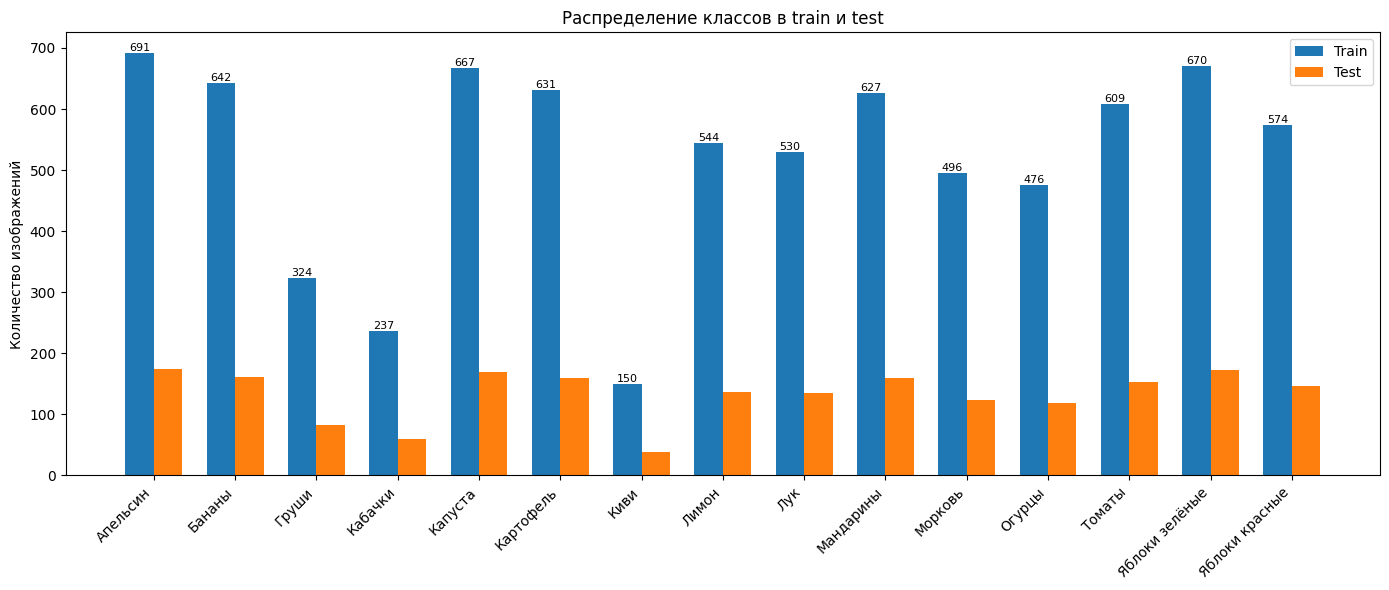

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# гарантируем порядок 0..14
classes = sorted(class_to_idx.values())
idx2class = {v: k for k, v in class_to_idx.items()}
class_names = [idx2class[i] for i in classes]

train_values = [train_counts.get(i, 0) for i in classes]
test_values  = [test_counts.get(i, 0) for i in classes]

x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(14, 6))

bars1 = plt.bar(x - width/2, train_values, width, label='Train')
bars2 = plt.bar(x + width/2, test_values,  width, label='Test')

plt.xticks(x, class_names, rotation=45, ha='right')
plt.ylabel('Количество изображений')
plt.title('Распределение классов в train и test')
plt.legend()

# подписи значений (по желанию)
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}',
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


In [26]:
import pandas as pd

rows = []

for class_idx, class_name in idx2class.items():
    train_cnt = train_counts.get(class_idx, 0)
    test_cnt  = test_counts.get(class_idx, 0)
    total     = train_cnt + test_cnt

    test_ratio = test_cnt / total if total > 0 else 0

    rows.append({
        "Класс": class_name,
        "Train": train_cnt,
        "Test": test_cnt,
        "Total": total,
        "Test %": round(test_ratio * 100, 2)
    })

df = pd.DataFrame(rows)
df

,Класс,Train,Test,Total,Test %
0,Апельсин,691,175,866,20.21
1,Бананы,642,162,804,20.15
2,Груши,324,82,406,20.20
3,Кабачки,237,60,297,20.20
4,Капуста,667,169,836,20.22
5,Картофель,631,160,791,20.23
6,Киви,150,38,188,20.21
7,Лимон,544,136,680,20.00
8,Лук,530,135,665,20.30
9,Мандарины,627,159,786,20.23


# Вернёмся к обучению

убрали дубли GaussNoise/Blur/RandomBrightnessContrast

сделали Rotate мягче

добавили RandomResizedCrop (это прям важно для 97%)

оставили шум/блюр, но редко и выборочно

In [27]:
train_transforms = A.Compose([
    A.RandomResizedCrop(size=(224, 224), scale=(0.70, 1.0), ratio=(0.75, 1.33), p=1.0),

    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=12, p=0.3),

    # A.ColorJitter(
    #     brightness=0.15,
    #     contrast=0.15,
    #     saturation=0.15,
    #     hue=0.03,
    #     p=0.7
    # ),

    A.OneOf([
        A.GaussNoise(std_range=(0.01, 0.05), p=1.0),
        A.GaussianBlur(blur_limit=(3, 5), p=1.0),
    ], p=0.2),

    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.ToTensorV2(),
])
val_transforms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.ToTensorV2(),
])


In [28]:
train_dataset = MyDataset(images_filepaths=train, name2label=class_to_idx, transform=train_transforms)
val_dataset   = MyDataset(images_filepaths=test,  name2label=class_to_idx, transform=val_transforms)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    worker_init_fn=seed_worker,
    generator=g
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,      # было 2
    shuffle=False,
    num_workers=4,      # было 1
    pin_memory=True,
    persistent_workers=True,
    worker_init_fn=seed_worker,
    generator=g
)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:424: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [30]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("logs")

In [31]:
def train(
    model,
    loss_fn,
    optimizer,
    train_loader,
    val_loader,
    device,
    writer=None,
    n_epoch=3,
    best_model_path='best_model.pth',
    scheduler=None
):
    best_val_acc = 0.0
    best_val_loss = float('inf')
    num_iter = 0

    for epoch in range(1, n_epoch + 1):
        model.train()

        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{n_epoch}", leave=True)

        for X_batch, y_batch in pbar:
            X_batch = X_batch.to(device, non_blocking=True)
            y_batch = y_batch.to(device, non_blocking=True)

            logits = model(X_batch)
            loss = loss_fn(logits, y_batch)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            bs = y_batch.size(0)
            total_loss += loss.item() * bs
            total_samples += bs

            y_pred = logits.argmax(dim=1)
            total_correct += (y_pred == y_batch).sum().item()

            avg_loss = total_loss / max(total_samples, 1)
            acc = total_correct / max(total_samples, 1)

            pbar.set_postfix(train_loss=f"{avg_loss:.4f}", train_acc=f"{acc:.4f}")

            num_iter += 1
            if writer is not None:
                writer.add_scalar("Loss/train", loss.item(), num_iter)
                writer.add_scalar("Accuracy/train", (y_pred == y_batch).float().mean().item(), num_iter)

        # --- VALIDATION ---
        val_acc, val_loss = evaluate(model, val_loader, loss_fn, device, desc=f"Val {epoch}/{n_epoch}")

        if scheduler is not None:
            scheduler.step()

        if writer is not None:
            writer.add_scalar("Loss/val", val_loss, epoch)
            writer.add_scalar("Accuracy/val", val_acc, epoch)

        print(f"Epoch {epoch}/{n_epoch}: val_loss={val_loss:.4f}  val_acc={val_acc:.4f}")

        # --- SAVE BEST MODEL ---
        is_better = (
            (val_acc > best_val_acc) or
            (val_acc == best_val_acc and val_loss < best_val_loss)
        )

        if is_better:
            best_val_acc = val_acc
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"Сохранена лучшая модель: val_acc={val_acc:.4f}, val_loss={val_loss:.4f}")

    print(f"\nЗагружаем лучшую модель (val_acc={best_val_acc:.4f}, val_loss={best_val_loss:.4f})")
    model.load_state_dict(torch.load(best_model_path, map_location=device))

    return model


## Три основные составляющие любого обучения:
### 1) Модель
### 2) Функция ошибок (loss function)
### 3) Оптимизатор

In [32]:
# import torch.nn as nn

# model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=0)


# num_features = model.num_features


# model.classifier = nn.Sequential(
#     nn.Dropout(0.5),
#     nn.Linear(num_features, 512),
#     nn.ReLU(),
#     nn.Dropout(0.3),
#     nn.Linear(512, 15)
# )

# model.to(device)

# # функция потерь с весами классов + сглаживание
# loss_fn = torch.nn.CrossEntropyLoss(
#     weight=class_weights,
#     label_smoothing=0.1
# )

# # оптимизатор AdamW (лучше для ConvNeXt)
# learning_rate = 3e-4
# optimizer = torch.optim.AdamW(
#     model.parameters(),
#     lr=learning_rate,
#     weight_decay=0.05
# )

In [33]:
model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=15)
model.to(device)

# функция потерь с весами классов + сглаживание
loss_fn = torch.nn.CrossEntropyLoss(
    weight=class_weights,
    label_smoothing=0.1
)

# оптимизатор AdamW (лучше для ConvNeXt)
learning_rate = 3e-4
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=0.05
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

In [34]:
best_model_path = 'best_model.pth'

from torch.optim.lr_scheduler import CosineAnnealingLR

scheduler = CosineAnnealingLR(
    optimizer,
    T_max=10,      # столько же, сколько эпох
    eta_min=1e-6   # чтобы lr не упал в 0
)


In [35]:
@torch.no_grad()
def evaluate(model, dataloader, loss_fn, device, desc="Val"):
    model.eval()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    pbar = tqdm(dataloader, desc=desc, leave=False)
    for X_batch, y_batch in pbar:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        logits = model(X_batch)
        loss = loss_fn(logits, y_batch)

        batch_size = y_batch.size(0)
        total_loss += loss.item() * batch_size

        y_pred = logits.argmax(dim=1)
        total_correct += (y_pred == y_batch).sum().item()
        total_samples += batch_size

        avg_loss = total_loss / max(total_samples, 1)
        acc = total_correct / max(total_samples, 1)
        pbar.set_postfix(loss=f"{avg_loss:.4f}", acc=f"{acc:.4f}")

    avg_loss = total_loss / max(total_samples, 1)
    accuracy = total_correct / max(total_samples, 1)
    return accuracy, avg_loss

In [36]:
# from tqdm import tqdm
# model = train(
#     model,
#     loss_fn,
#     optimizer,
#     train_loader,
#     val_loader,
#     device,
#     writer,
#     n_epoch=20,
#     scheduler=scheduler,
#     best_model_path=best_model_path
# )


In [37]:
# from sklearn.model_selection import StratifiedKFold
# import numpy as np
# from tqdm import tqdm

# # ШАГ 1: Создаем списки файлов
# train_paths, test_paths = train_test_split_from_directory(
#     root_path=dataset_path,
#     train_size=0.8,
#     seed=SEED
# )

# print(f"Тренировочных: {len(train_paths)}")

# # ШАГ 2: Создаем метки для K-Fold
# all_paths = train_paths
# all_labels = []
# for path in all_paths:
#     class_name = os.path.basename(os.path.dirname(os.path.dirname(path)))
#     all_labels.append(class_to_idx[class_name])

# print(f"Всего изображений для K-Fold: {len(all_paths)}")

# # ШАГ 3: K-Fold
# n_folds = 5
# skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=SEED)

# fold_models = []  # для сохранения моделей
# fold_scores = []  # для сохранения метрик

# for fold, (train_idx, val_idx) in enumerate(skf.split(all_paths, all_labels)):

#     print(f"FOLD {fold + 1}/{n_folds}")


#     # СОЗДАЕМ НОВУЮ МОДЕЛЬ для каждого фолда
#     model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=0)
#     model.classifier = nn.Sequential(
#         nn.Dropout(0.5),
#         nn.Linear(model.num_features, 512),
#         nn.ReLU(),
#         nn.Dropout(0.3),
#         nn.Linear(512, 15)
#     )
#     model.to(device)

#     # Оптимизатор
#     optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.05)

#     # Функция потерь
#     loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

#     # DataLoader для этого фолда
#     train_paths_fold = [all_paths[i] for i in train_idx]
#     val_paths_fold = [all_paths[i] for i in val_idx]

#     print(f"Тренировочных: {len(train_paths_fold)}, Валидационных: {len(val_paths_fold)}")

#     train_dataset = MyDataset(train_paths_fold, class_to_idx, train_transforms)
#     val_dataset = MyDataset(val_paths_fold, class_to_idx, val_transforms)

#     train_loader = DataLoader(
#         train_dataset,
#         batch_size=32,
#         shuffle=True,
#         num_workers=4,
#         pin_memory=True
#     )
#     val_loader = DataLoader(
#         val_dataset,
#         batch_size=64,
#         shuffle=False,
#         num_workers=4,
#         pin_memory=True
#     )

#     # Путь для сохранения модели этого фолда
#     best_model_path = f'best_model_fold_{fold}.pth'

#     # ОБУЧАЕМ с вашей функцией train
#     model = train(
#         model,           # модель
#         loss_fn,         # функция потерь
#         optimizer,       # оптимизатор
#         train_loader,    # загрузчик для этого фолда
#         val_loader,      # загрузчик для этого фолда
#         device,          # устройство
#         writer,          # tensorboard
#         n_epoch=5,      # количество эпох
#         scheduler=scheduler,  # планировщик
#         best_model_path=best_model_path  # путь сохранения
#     )

#     # Сохраняем модель для ансамбля
#     fold_models.append(model)

#     # Оцениваем финальную точность на валидации этого фолда
#     val_acc, val_loss = evaluate(model, val_loader, loss_fn, device)
#     fold_scores.append(val_acc)
#     print(f"Fold {fold + 1} финальная val_acc: {val_acc:.4f}")

# print(f"\n{'='*50}")
# print(f"РЕЗУЛЬТАТЫ K-FOLD:")
# print(f"{'='*50}")
# print(f"Средняя точность: {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}")
# print(f"Моделей в ансамбле: {len(fold_models)}")

In [38]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
from tqdm import tqdm


train_paths, test_paths = train_test_split_from_directory(
    root_path=dataset_path,
    train_size=0.8,
    seed=SEED
)

print(f"Тренировочных: {len(train_paths)}")


all_paths = train_paths
all_labels = []
for path in all_paths:
    class_name = os.path.basename(os.path.dirname(os.path.dirname(path)))
    all_labels.append(class_to_idx[class_name])

print(f"Всего изображений для K-Fold: {len(all_paths)}")


n_folds = 4
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=SEED)


architectures = [
    {
        'name': 'efficientnet_b3',
        'dropout1': 0.4,
        'dropout2': 0.2,
        'hidden': 512,
        'lr': 3e-4,
        'epochs': 8,
        'weight_decay': 0.03
    },
    {
        'name': 'efficientnet_b4',
        'dropout1': 0.4,
        'dropout2': 0.2,
        'hidden': 512,
        'lr': 2.5e-4,
        'epochs': 12,
        'weight_decay': 0.03
    },
    {
        'name': 'resnet50',
        'dropout1': 0.5,
        'dropout2': 0.3,
        'hidden': 512,
        'lr': 2.5e-4,
        'epochs': 12,
        'weight_decay': 0.04
    },
    {
        'name': 'tf_efficientnet_b4_ns',
        'dropout1': 0.4,
        'dropout2': 0.2,
        'hidden': 512,
        'lr': 2.5e-4,
        'epochs': 10,
        'weight_decay': 0.03
    }
]

fold_models = []
fold_scores = []
fold_arch_names = []
fold_best_epochs = []

for fold, (train_idx, val_idx) in enumerate(skf.split(all_paths, all_labels)):
    arch_config = architectures[fold % len(architectures)]
    arch_name = arch_config['name']

    print(f"\n{'='*50}")
    print(f"FOLD {fold + 1}/{n_folds} - Архитектура: {arch_name}")
    print(f"{'='*50}")


    model = timm.create_model(arch_name, pretrained=True, num_classes=0)


    if arch_name.startswith('resnet'):
        model.fc = nn.Sequential(
            nn.Dropout(arch_config['dropout1']),
            nn.Linear(model.num_features, arch_config['hidden']),
            nn.ReLU(),
            nn.Dropout(arch_config['dropout2']),
            nn.Linear(arch_config['hidden'], 15)
        )

    elif arch_name.startswith('vit'):
        model.head = nn.Sequential(
            nn.Dropout(arch_config['dropout1']),
            nn.Linear(model.num_features, arch_config['hidden']),
            nn.ReLU(),
            nn.Dropout(arch_config['dropout2']),
            nn.Linear(arch_config['hidden'], 15)
        )

    elif arch_name.startswith('convnext'):
        model.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(arch_config['dropout1']),
            nn.Linear(model.num_features, arch_config['hidden']),
            nn.ReLU(),
            nn.Dropout(arch_config['dropout2']),
            nn.Linear(arch_config['hidden'], 15)
        )
        print(f"   ConvNeXt настроен: num_features={model.num_features} -> {arch_config['hidden']} -> 15")

    elif arch_name.startswith('efficientnet') or arch_name.startswith('tf_efficientnet'):
        # Для EfficientNet (включая tf_efficientnet) - заменяем classifier
        model.classifier = nn.Sequential(
            nn.Dropout(arch_config['dropout1']),
            nn.Linear(model.num_features, arch_config['hidden']),
            nn.ReLU(),
            nn.Dropout(arch_config['dropout2']),
            nn.Linear(arch_config['hidden'], 15)
        )
        print(f"   EfficientNet настроен: num_features={model.num_features} -> {arch_config['hidden']} -> 15")

    else:

        classifier = nn.Sequential(
            nn.Dropout(arch_config['dropout1']),
            nn.Linear(model.num_features, arch_config['hidden']),
            nn.ReLU(),
            nn.Dropout(arch_config['dropout2']),
            nn.Linear(arch_config['hidden'], 15)
        )

        if hasattr(model, 'head'):
            model.head = classifier
        elif hasattr(model, 'fc'):
            model.fc = classifier
        else:
            model.classifier = classifier

    model.to(device)


    test_input = torch.randn(2, 3, 224, 224).to(device)
    try:
        test_output = model(test_input)
        print(f"   Выход модели: {test_output.shape} (ожидается [2, 15])")
        assert test_output.shape[1] == 15, f"Ошибка: выход {test_output.shape[1]}, ожидается 15"
    except Exception as e:
        print(f"   Ошибка в архитектуре {arch_name}: {e}")
        print("Проверьте структуру модели:")
        print(model)
        raise

    # Оптимизатор
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=arch_config['lr'],
        weight_decay=arch_config['weight_decay']
    )


    loss_fn = torch.nn.CrossEntropyLoss(
        weight=class_weights,
        label_smoothing=0.1
    )


    train_paths_fold = [all_paths[i] for i in train_idx]
    val_paths_fold = [all_paths[i] for i in val_idx]

    print(f"   Тренировочных: {len(train_paths_fold)}, Валидационных: {len(val_paths_fold)}")

    train_dataset = MyDataset(train_paths_fold, class_to_idx, train_transforms)
    val_dataset = MyDataset(val_paths_fold, class_to_idx, val_transforms)

    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=64,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )


    best_model_path = f'best_model_{arch_name}_fold_{fold}.pth'


    n_epochs = arch_config['epochs']
    print(f"   Обучение {n_epochs} эпох...")

    model = train(
        model, loss_fn, optimizer, train_loader, val_loader,
        device, writer, n_epoch=n_epochs, scheduler=scheduler,
        best_model_path=best_model_path
    )


    fold_models.append(model)
    fold_arch_names.append(arch_name)


    val_acc, val_loss = evaluate(model, val_loader, loss_fn, device)
    fold_scores.append(val_acc)
    fold_best_epochs.append(n_epochs)
    print(f"   Fold {fold + 1} ({arch_name}) val_acc: {val_acc:.4f} (обучен {n_epochs} эпох)")


for name, score, epochs in zip(fold_arch_names, fold_scores, fold_best_epochs):
    print(f"  {name}: {score:.4f} (обучен {epochs} эпох)")
print(f"\n Средняя точность: {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}")
print(f" Моделей в ансамбле: {len(fold_models)}")

# Анализ лучших параметров
best_idx = np.argmax(fold_scores)
print(f"\n Лучшая модель: {fold_arch_names[best_idx]} с точностью {fold_scores[best_idx]:.4f}")
print(f"   Параметры: {architectures[best_idx]}")

Тренировочных: 7868
Всего изображений для K-Fold: 7868

FOLD 1/4 - Архитектура: efficientnet_b3
  ✓ EfficientNet настроен: num_features=1536 -> 512 -> 15


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:424: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


   Выход модели: torch.Size([2, 15]) (ожидается [2, 15])
   Тренировочных: 5901, Валидационных: 1967
   Обучение 8 эпох...


Epoch 1/8:   0%|          | 0/185 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:432: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()
Epoch 1/8: 100%|██████████| 185/185 [01:03<00:00,  2.92it/s, train_acc=0.6779, train_loss=1.5033]
/tmp/ipython-input-449/884854971.py:58: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorc

Epoch 1/8: val_loss=1.0631  val_acc=0.8592
Сохранена лучшая модель: val_acc=0.8592, val_loss=1.0631


Epoch 2/8: 100%|██████████| 185/185 [00:58<00:00,  3.16it/s, train_acc=0.8965, train_loss=0.9339]


Epoch 2/8: val_loss=0.9392  val_acc=0.9075
Сохранена лучшая модель: val_acc=0.9075, val_loss=0.9392


Epoch 3/8: 100%|██████████| 185/185 [00:58<00:00,  3.18it/s, train_acc=0.9375, train_loss=0.8299]


Epoch 3/8: val_loss=0.9341  val_acc=0.8978


Epoch 4/8: 100%|██████████| 185/185 [01:02<00:00,  2.96it/s, train_acc=0.9546, train_loss=0.7780]


Epoch 4/8: val_loss=0.9071  val_acc=0.9217
Сохранена лучшая модель: val_acc=0.9217, val_loss=0.9071


Epoch 5/8: 100%|██████████| 185/185 [01:01<00:00,  3.00it/s, train_acc=0.9686, train_loss=0.7450]


Epoch 5/8: val_loss=0.9194  val_acc=0.9126


Epoch 6/8: 100%|██████████| 185/185 [01:01<00:00,  3.00it/s, train_acc=0.9756, train_loss=0.7247]


Epoch 6/8: val_loss=0.9067  val_acc=0.9176


Epoch 7/8: 100%|██████████| 185/185 [01:03<00:00,  2.90it/s, train_acc=0.9786, train_loss=0.7124]


Epoch 7/8: val_loss=0.8935  val_acc=0.9227
Сохранена лучшая модель: val_acc=0.9227, val_loss=0.8935


Epoch 8/8: 100%|██████████| 185/185 [01:02<00:00,  2.96it/s, train_acc=0.9839, train_loss=0.6982]


Epoch 8/8: val_loss=0.8765  val_acc=0.9293
Сохранена лучшая модель: val_acc=0.9293, val_loss=0.8765

Загружаем лучшую модель (val_acc=0.9293, val_loss=0.8765)


  ✅ Fold 1 (efficientnet_b3) val_acc: 0.9293 (обучен 8 эпох)

FOLD 2/4 - Архитектура: efficientnet_b4


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

  ✓ EfficientNet настроен: num_features=1792 -> 512 -> 15
   Выход модели: torch.Size([2, 15]) (ожидается [2, 15])
   Тренировочных: 5901, Валидационных: 1967
   Обучение 12 эпох...


Epoch 1/12: 100%|██████████| 185/185 [01:28<00:00,  2.09it/s, train_acc=0.5752, train_loss=1.7670]


Epoch 1/12: val_loss=1.1038  val_acc=0.8597
Сохранена лучшая модель: val_acc=0.8597, val_loss=1.1038


Epoch 2/12: 100%|██████████| 185/185 [01:25<00:00,  2.16it/s, train_acc=0.8488, train_loss=1.0645]


Epoch 2/12: val_loss=0.9812  val_acc=0.8882
Сохранена лучшая модель: val_acc=0.8882, val_loss=0.9812


Epoch 3/12: 100%|██████████| 185/185 [01:25<00:00,  2.16it/s, train_acc=0.9097, train_loss=0.9080]


Epoch 3/12: val_loss=0.9301  val_acc=0.9090
Сохранена лучшая модель: val_acc=0.9090, val_loss=0.9301


Epoch 4/12: 100%|██████████| 185/185 [01:25<00:00,  2.17it/s, train_acc=0.9365, train_loss=0.8283]


Epoch 4/12: val_loss=0.9214  val_acc=0.9131
Сохранена лучшая модель: val_acc=0.9131, val_loss=0.9214


Epoch 5/12: 100%|██████████| 185/185 [01:25<00:00,  2.16it/s, train_acc=0.9576, train_loss=0.7776]


Epoch 5/12: val_loss=0.8852  val_acc=0.9207
Сохранена лучшая модель: val_acc=0.9207, val_loss=0.8852


Epoch 6/12: 100%|██████████| 185/185 [01:25<00:00,  2.16it/s, train_acc=0.9678, train_loss=0.7480]


Epoch 6/12: val_loss=0.8852  val_acc=0.9283
Сохранена лучшая модель: val_acc=0.9283, val_loss=0.8852


Epoch 7/12: 100%|██████████| 185/185 [01:25<00:00,  2.17it/s, train_acc=0.9766, train_loss=0.7234]


Epoch 7/12: val_loss=0.8664  val_acc=0.9293
Сохранена лучшая модель: val_acc=0.9293, val_loss=0.8664


Epoch 8/12: 100%|██████████| 185/185 [01:25<00:00,  2.15it/s, train_acc=0.9846, train_loss=0.7028]


Epoch 8/12: val_loss=0.8626  val_acc=0.9324
Сохранена лучшая модель: val_acc=0.9324, val_loss=0.8626


Epoch 9/12: 100%|██████████| 185/185 [01:25<00:00,  2.16it/s, train_acc=0.9871, train_loss=0.6947]


Epoch 9/12: val_loss=0.8738  val_acc=0.9278


Epoch 10/12: 100%|██████████| 185/185 [01:25<00:00,  2.17it/s, train_acc=0.9892, train_loss=0.6882]


Epoch 10/12: val_loss=0.8641  val_acc=0.9344
Сохранена лучшая модель: val_acc=0.9344, val_loss=0.8641


Epoch 11/12: 100%|██████████| 185/185 [01:25<00:00,  2.15it/s, train_acc=0.9897, train_loss=0.6831]


Epoch 11/12: val_loss=0.8784  val_acc=0.9283


Epoch 12/12: 100%|██████████| 185/185 [01:25<00:00,  2.16it/s, train_acc=0.9907, train_loss=0.6774]


Epoch 12/12: val_loss=0.8624  val_acc=0.9314

Загружаем лучшую модель (val_acc=0.9344, val_loss=0.8641)


  ✅ Fold 2 (efficientnet_b4) val_acc: 0.9344 (обучен 12 эпох)

FOLD 3/4 - Архитектура: resnet50


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

   Выход модели: torch.Size([2, 15]) (ожидается [2, 15])
   Тренировочных: 5901, Валидационных: 1967
   Обучение 12 эпох...


Epoch 1/12: 100%|██████████| 185/185 [01:17<00:00,  2.39it/s, train_acc=0.4691, train_loss=2.0386]


Epoch 1/12: val_loss=1.2782  val_acc=0.7697
Сохранена лучшая модель: val_acc=0.7697, val_loss=1.2782


Epoch 2/12: 100%|██████████| 185/185 [01:06<00:00,  2.80it/s, train_acc=0.7858, train_loss=1.2164]


Epoch 2/12: val_loss=1.0937  val_acc=0.8510
Сохранена лучшая модель: val_acc=0.8510, val_loss=1.0937


Epoch 3/12: 100%|██████████| 185/185 [01:06<00:00,  2.78it/s, train_acc=0.8412, train_loss=1.0605]


Epoch 3/12: val_loss=1.0231  val_acc=0.8704
Сохранена лучшая модель: val_acc=0.8704, val_loss=1.0231


Epoch 4/12: 100%|██████████| 185/185 [01:06<00:00,  2.79it/s, train_acc=0.8834, train_loss=0.9671]


Epoch 4/12: val_loss=0.9687  val_acc=0.8866
Сохранена лучшая модель: val_acc=0.8866, val_loss=0.9687


Epoch 5/12: 100%|██████████| 185/185 [01:06<00:00,  2.77it/s, train_acc=0.9032, train_loss=0.9134]


Epoch 5/12: val_loss=0.9158  val_acc=0.9151
Сохранена лучшая модель: val_acc=0.9151, val_loss=0.9158


Epoch 6/12: 100%|██████████| 185/185 [01:06<00:00,  2.78it/s, train_acc=0.9200, train_loss=0.8590]


Epoch 6/12: val_loss=0.9178  val_acc=0.9126


Epoch 7/12: 100%|██████████| 185/185 [01:05<00:00,  2.80it/s, train_acc=0.9359, train_loss=0.8245]


Epoch 7/12: val_loss=0.8931  val_acc=0.9243
Сохранена лучшая модель: val_acc=0.9243, val_loss=0.8931


Epoch 8/12: 100%|██████████| 185/185 [01:06<00:00,  2.79it/s, train_acc=0.9503, train_loss=0.7946]


Epoch 8/12: val_loss=0.9010  val_acc=0.9222


Epoch 9/12: 100%|██████████| 185/185 [01:06<00:00,  2.78it/s, train_acc=0.9541, train_loss=0.7780]


Epoch 9/12: val_loss=0.9002  val_acc=0.9222


Epoch 10/12: 100%|██████████| 185/185 [01:06<00:00,  2.79it/s, train_acc=0.9641, train_loss=0.7551]


Epoch 10/12: val_loss=0.8901  val_acc=0.9253
Сохранена лучшая модель: val_acc=0.9253, val_loss=0.8901


Epoch 11/12: 100%|██████████| 185/185 [01:06<00:00,  2.78it/s, train_acc=0.9663, train_loss=0.7539]


Epoch 11/12: val_loss=0.8969  val_acc=0.9166


Epoch 12/12: 100%|██████████| 185/185 [01:06<00:00,  2.77it/s, train_acc=0.9686, train_loss=0.7467]


Epoch 12/12: val_loss=0.8984  val_acc=0.9258
Сохранена лучшая модель: val_acc=0.9258, val_loss=0.8984

Загружаем лучшую модель (val_acc=0.9258, val_loss=0.8984)


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b4_ns to current tf_efficientnet_b4.ns_jft_in1k.
  model = create_fn(


  ✅ Fold 3 (resnet50) val_acc: 0.9258 (обучен 12 эпох)

FOLD 4/4 - Архитектура: tf_efficientnet_b4_ns


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

  ✓ EfficientNet настроен: num_features=1792 -> 512 -> 15
   Выход модели: torch.Size([2, 15]) (ожидается [2, 15])
   Тренировочных: 5901, Валидационных: 1967
   Обучение 10 эпох...


Epoch 1/10: 100%|██████████| 185/185 [01:27<00:00,  2.11it/s, train_acc=0.7055, train_loss=1.4715]


Epoch 1/10: val_loss=0.9621  val_acc=0.8943
Сохранена лучшая модель: val_acc=0.8943, val_loss=0.9621


Epoch 2/10: 100%|██████████| 185/185 [01:26<00:00,  2.13it/s, train_acc=0.8985, train_loss=0.9227]


Epoch 2/10: val_loss=0.9285  val_acc=0.9080
Сохранена лучшая модель: val_acc=0.9080, val_loss=0.9285


Epoch 3/10: 100%|██████████| 185/185 [01:26<00:00,  2.13it/s, train_acc=0.9412, train_loss=0.8069]


Epoch 3/10: val_loss=0.9007  val_acc=0.9298
Сохранена лучшая модель: val_acc=0.9298, val_loss=0.9007


Epoch 4/10: 100%|██████████| 185/185 [01:26<00:00,  2.13it/s, train_acc=0.9615, train_loss=0.7545]


Epoch 4/10: val_loss=0.8722  val_acc=0.9329
Сохранена лучшая модель: val_acc=0.9329, val_loss=0.8722


Epoch 5/10: 100%|██████████| 185/185 [01:27<00:00,  2.12it/s, train_acc=0.9709, train_loss=0.7257]


Epoch 5/10: val_loss=0.8771  val_acc=0.9309


Epoch 6/10: 100%|██████████| 185/185 [01:26<00:00,  2.13it/s, train_acc=0.9715, train_loss=0.7316]


Epoch 6/10: val_loss=0.8928  val_acc=0.9278


Epoch 7/10: 100%|██████████| 185/185 [01:26<00:00,  2.14it/s, train_acc=0.9786, train_loss=0.7154]


Epoch 7/10: val_loss=0.8914  val_acc=0.9268


Epoch 8/10: 100%|██████████| 185/185 [01:26<00:00,  2.13it/s, train_acc=0.9783, train_loss=0.7051]


Epoch 8/10: val_loss=0.8846  val_acc=0.9278


Epoch 9/10: 100%|██████████| 185/185 [01:27<00:00,  2.13it/s, train_acc=0.9851, train_loss=0.6915]


Epoch 9/10: val_loss=0.8945  val_acc=0.9258


Epoch 10/10: 100%|██████████| 185/185 [01:27<00:00,  2.12it/s, train_acc=0.9831, train_loss=0.6927]


Epoch 10/10: val_loss=0.8755  val_acc=0.9349
Сохранена лучшая модель: val_acc=0.9349, val_loss=0.8755

Загружаем лучшую модель (val_acc=0.9349, val_loss=0.8755)


  ✅ Fold 4 (tf_efficientnet_b4_ns) val_acc: 0.9349 (обучен 10 эпох)

🎯 РЕЗУЛЬТАТЫ АНСАМБЛЯ РАЗНЫХ АРХИТЕКТУР:
  efficientnet_b3: 0.9293 (обучен 8 эпох)
  efficientnet_b4: 0.9344 (обучен 12 эпох)
  resnet50: 0.9258 (обучен 12 эпох)
  tf_efficientnet_b4_ns: 0.9349 (обучен 10 эпох)

📊 Средняя точность: 0.9311 ± 0.0038
🤖 Моделей в ансамбле: 4

🏆 Лучшая модель: tf_efficientnet_b4_ns с точностью 0.9349
   Параметры: {'name': 'tf_efficientnet_b4_ns', 'dropout1': 0.4, 'dropout2': 0.2, 'hidden': 512, 'lr': 0.00025, 'epochs': 10, 'weight_decay': 0.03}


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:432: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


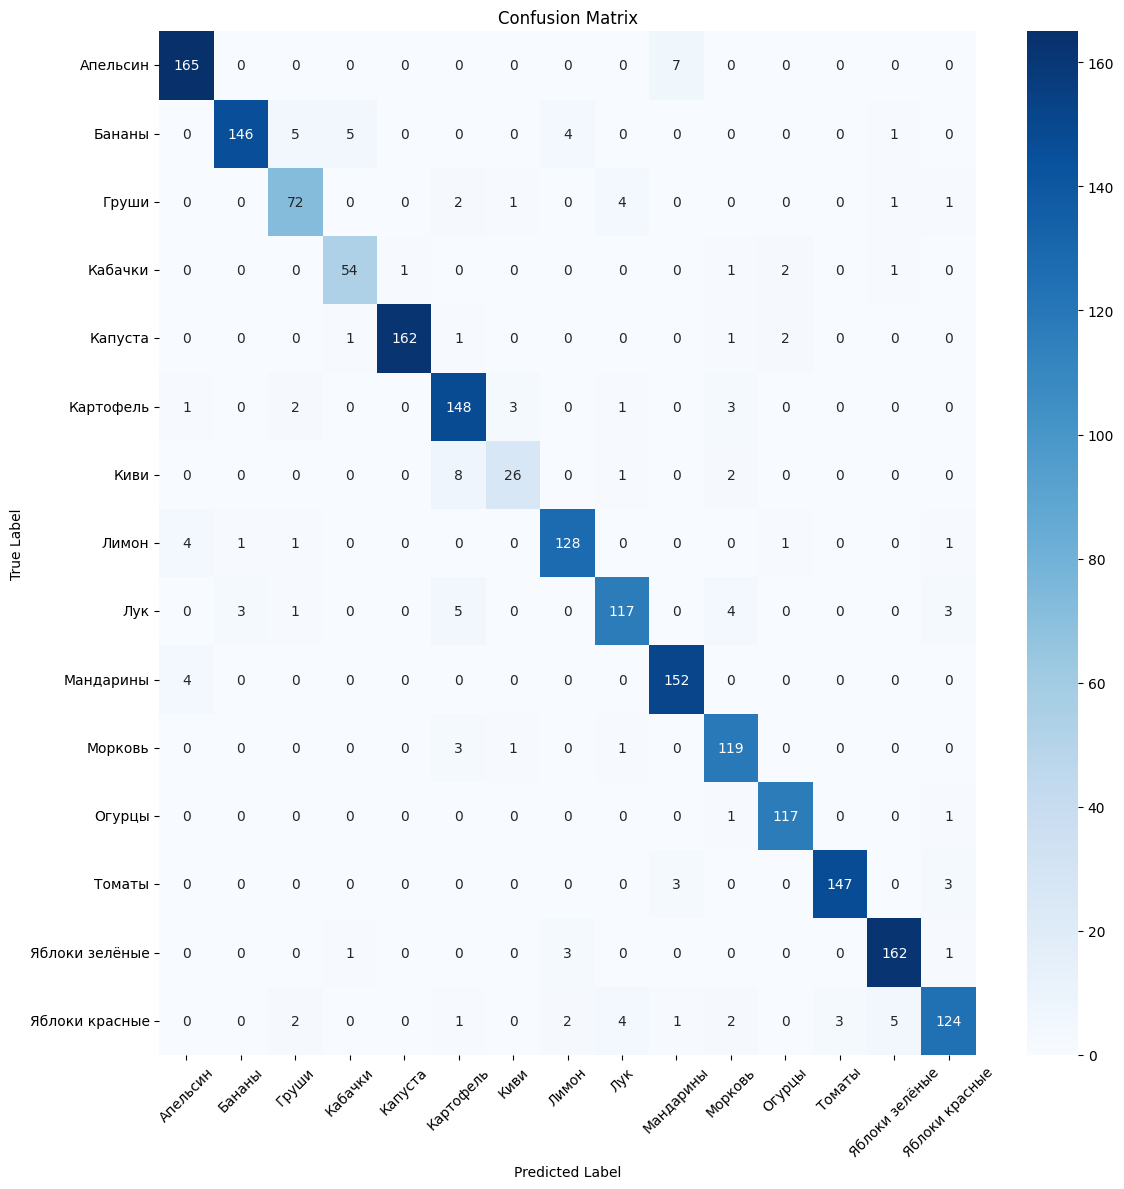

In [39]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in val_loader:  # используем test_loader
        X = X.to(device)
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y.numpy())
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 12))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Посмотрим на итоговые метрики

In [40]:
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix

@torch.no_grad()
def sklearn_report(model, dataloader, device, idx2class=None, digits=4):
    model.eval()

    y_true, y_pred = [], []

    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device, non_blocking=True)

        logits = model(X_batch)
        preds = logits.argmax(dim=1).cpu().numpy()

        y_pred.append(preds)
        y_true.append(y_batch.numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    # names for report
    if idx2class is None:
        target_names = None
        labels = None
    else:
        labels = sorted(idx2class.keys())
        target_names = [idx2class[i] for i in labels]

    rep = classification_report(
        y_true, y_pred,
        labels=labels,
        target_names=target_names,
        digits=digits,
        zero_division=0
    )
    print(rep)

In [41]:
sklearn_report(model, val_loader, device, idx2class=idx2class)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:432: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


                precision    recall  f1-score   support

      Апельсин     0.9483    0.9593    0.9538       172
        Бананы     0.9733    0.9068    0.9389       161
         Груши     0.8675    0.8889    0.8780        81
       Кабачки     0.8852    0.9153    0.9000        59
       Капуста     0.9939    0.9701    0.9818       167
     Картофель     0.8810    0.9367    0.9080       158
          Киви     0.8387    0.7027    0.7647        37
         Лимон     0.9343    0.9412    0.9377       136
           Лук     0.9141    0.8797    0.8966       133
     Мандарины     0.9325    0.9744    0.9530       156
       Морковь     0.8947    0.9597    0.9261       124
        Огурцы     0.9590    0.9832    0.9710       119
        Томаты     0.9800    0.9608    0.9703       153
Яблоки зелёные     0.9529    0.9701    0.9614       167
Яблоки красные     0.9254    0.8611    0.8921       144

      accuracy                         0.9349      1967
     macro avg     0.9254    0.9207    0.9222 

# Оформляем предсказание

In [48]:
# Пути к тестовым данным и сабмишену
data_folder = os.path.join(path, 'dl-lab-1-image-classification — наш')
test_images_dir = os.path.join(data_folder, 'test_images', 'test_images')
submission_path = os.path.join(data_folder, 'sample_submission.csv')
output_path = "submission.csv"

print(f"Путь к тестовым изображениям: {test_images_dir}")
print(f"Путь к sample_submission.csv: {submission_path}")
print(f"Файл существует: {os.path.exists(submission_path)}")

Путь к тестовым изображениям: ./my_dataset/dl-lab-1-image-classification — наш/test_images/test_images
Путь к sample_submission.csv: ./my_dataset/dl-lab-1-image-classification — наш/sample_submission.csv
Файл существует: True


In [43]:
# import pandas as pd
# import torch.nn.functional as F
# from tqdm import tqdm

# # Читаем файл сабмишена
# submission = pd.read_csv(submission_path)
# print(f"Загружено {len(submission)} строк из sample_submission.csv")

# model.eval()
# pred_labels = []

# # with torch.no_grad():
# #     for image_id in tqdm(submission["image_id"], desc="Predicting"):
# #         image_path = os.path.join(test_images_dir, image_id)

# #         # Проверка существования файла
# #         if not os.path.exists(image_path):
# #             print(f"Предупреждение: файл не найден {image_path}")
# #             continue

# #         image = cv2.imdecode(
# #             np.fromfile(image_path, dtype=np.uint8),
# #             cv2.IMREAD_COLOR
# #         )
# #         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# #         if val_transforms is not None:
# #             image = val_transforms(image=image)["image"]

# #         image = image.unsqueeze(0).to(device)

# #         logits = model(image)
# #         pred_idx = logits.argmax(dim=1).item()

# #         pred_labels.append(pred_idx)

# # print(f"Сделано предсказаний: {len(pred_labels)}")
# ################################################новый вариант

# # with torch.no_grad():
# #     for image_id in tqdm(submission["image_id"], desc="Predicting with Advanced TTA (5 augs)"):
# #         image_path = os.path.join(test_images_dir, image_id)

# #         # Проверка существования файла
# #         if not os.path.exists(image_path):
# #             print(f"Предупреждение: файл не найден {image_path}")
# #             continue

# #         # Загружаем изображение
# #         image = cv2.imdecode(
# #             np.fromfile(image_path, dtype=np.uint8),
# #             cv2.IMREAD_COLOR
# #         )
# #         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# #         # Применяем валидационные трансформации
# #         if val_transforms is not None:
# #             augmented = val_transforms(image=image)
# #             image_tensor = augmented["image"]

# #         image_tensor = image_tensor.unsqueeze(0).to(device)

# #         all_probs = []

# #         # 1. Оригинал
# #         logits = model(image_tensor)
# #         all_probs.append(torch.softmax(logits, dim=1))

# #         # 2. Горизонтальный флип
# #         flipped_h = torch.flip(image_tensor, dims=[3])
# #         logits = model(flipped_h)
# #         all_probs.append(torch.softmax(logits, dim=1))

# #         # 3. Поворот на 90 градусов
# #         rotated_90 = torch.rot90(image_tensor, k=1, dims=[2, 3])
# #         logits = model(rotated_90)
# #         all_probs.append(torch.softmax(logits, dim=1))

# #         # 4. Поворот на 180 градусов
# #         rotated_180 = torch.rot90(image_tensor, k=2, dims=[2, 3])
# #         logits = model(rotated_180)
# #         all_probs.append(torch.softmax(logits, dim=1))

# #         # 5. Поворот на 270 градусов
# #         rotated_270 = torch.rot90(image_tensor, k=3, dims=[2, 3])
# #         logits = model(rotated_270)
# #         all_probs.append(torch.softmax(logits, dim=1))

# #         # Усредняем предсказания
# #         probs_avg = torch.mean(torch.stack(all_probs), dim=0)


# #         pred_idx = probs_avg.argmax(dim=1).item()
# #         pred_labels.append(pred_idx)

# # print(f"Сделано предсказаний с расширенным TTA (5 аугментаций): {len(pred_labels)}")
# with torch.no_grad():
#     for image_id in tqdm(submission["image_id"], desc="Predicting with TTA"):
#         image_path = os.path.join(test_images_dir, image_id)
#         image = cv2.imdecode(np.fromfile(image_path, dtype=np.uint8), cv2.IMREAD_COLOR)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#         # Базовое изображение
#         image_tensor = val_transforms(image=image)["image"].unsqueeze(0).to(device)

#         all_probs = []

#         # Оригинал
#         all_probs.append(torch.softmax(model(image_tensor), dim=1))

#         # Горизонтальный флип
#         all_probs.append(torch.softmax(model(torch.flip(image_tensor, dims=[3])), dim=1))

#         # Вертикальный флип (иногда помогает)
#         all_probs.append(torch.softmax(model(torch.flip(image_tensor, dims=[2])), dim=1))

#         # Небольшое масштабирование через RandomResizedCrop
#         for scale in [0.9, 1.1]:
#             scaled = F.interpolate(image_tensor, scale_factor=scale, mode='bilinear')
#             scaled = F.interpolate(scaled, size=(224, 224), mode='bilinear')
#             all_probs.append(torch.softmax(model(scaled), dim=1))

#         # Усредняем
#         probs_avg = torch.mean(torch.stack(all_probs), dim=0)
#         pred_idx = probs_avg.argmax(dim=1).item()
#         pred_labels.append(pred_idx)
# print(f"Сделано предсказаний: {len(pred_labels)}")

In [45]:


!pip install catboost
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split




val_dataset_full = MyDataset(test_paths, class_to_idx, val_transforms)
val_loader_full = DataLoader(
    val_dataset_full,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

all_model_probs_val = []
true_labels_val = []

for model_idx, fold_model in enumerate(fold_models):
    fold_model.eval()
    model_probs_val = []

    with torch.no_grad():
        for X_batch, y_batch in tqdm(val_loader_full, desc=f"Модель {model_idx} на валидации"):
            X_batch = X_batch.to(device)
            probs = torch.softmax(fold_model(X_batch), dim=1)
            model_probs_val.append(probs.cpu().numpy())

            if model_idx == 0:
                true_labels_val.extend(y_batch.numpy())

    all_model_probs_val.append(np.vstack(model_probs_val))

true_labels_val = np.array(true_labels_val)
n_models = len(fold_models)
n_classes = 15
n_samples = len(true_labels_val)

print(f"Собрано предсказаний: {n_samples} образцов, {n_models} моделей")


X_catboost = []
for i in range(n_samples):
    sample_features = []
    for model_idx in range(n_models):
        sample_features.extend(all_model_probs_val[model_idx][i])
    X_catboost.append(sample_features)

X_catboost = np.array(X_catboost)
y_catboost = true_labels_val


X_train, X_val, y_train, y_val = train_test_split(
    X_catboost, y_catboost, test_size=0.2, random_state=42, stratify=y_catboost
)


cb_model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.05,
    depth=8,
    loss_function='MultiClass',
    verbose=False,
    random_seed=42
)

cb_model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)


feature_importance = cb_model.get_feature_importance()
cb_weights = []
for model_idx in range(n_models):
    start_idx = model_idx * n_classes
    end_idx = (model_idx + 1) * n_classes
    model_importance = np.sum(feature_importance[start_idx:end_idx])
    cb_weights.append(model_importance)


cb_weights = np.array(cb_weights)
cb_weights = cb_weights / cb_weights.sum() * len(cb_weights)

print(f"\nВеса от CatBoost: {[f'{w:.4f}' for w in cb_weights]}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 MB 9.7 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:424: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()



ОПТИМИЗАЦИЯ ВЕСОВ ЧЕРЕЗ CatBoost


Модель 0 на валидации:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:432: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()
Модель 3 на валидации: 100%|██████████| 32/32 [00:09<00:00,  3.45it/s]


Собрано предсказаний: 1991 образцов, 4 моделей

Веса от CatBoost: ['1.0758', '1.0527', '0.8127', '1.0588']


In [49]:
import pandas as pd
import torch.nn.functional as F
from tqdm import tqdm


submission = pd.read_csv(submission_path)
print(f"Загружено {len(submission)} строк из sample_submission.csv")


for model in fold_models:
    model.eval()


model_weights = cb_weights
print(f"Веса от CatBoost: {[f'{w:.4f}' for w in model_weights]}")
print(f"Средний вес: {np.mean(model_weights):.4f}")

weights_tensor = torch.tensor(model_weights).to(device)


def clahe_augmentation(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    lab[:,:,0] = clahe.apply(lab[:,:,0])
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

pred_labels = []

with torch.no_grad():
    for image_id in tqdm(submission["image_id"], desc="Predicting with Advanced TTA"):
        image_path = os.path.join(test_images_dir, image_id)

        if not os.path.exists(image_path):
            print(f"Предупреждение: файл не найден {image_path}")
            pred_labels.append(0)
            continue

        image = cv2.imdecode(np.fromfile(image_path, dtype=np.uint8), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


        image_tensor = val_transforms(image=image)["image"].unsqueeze(0).to(device)


        image_clahe = clahe_augmentation(image)
        image_tensor_clahe = val_transforms(image=image_clahe)["image"].unsqueeze(0).to(device)


        weighted_probs_sum = None


        for model_idx, fold_model in enumerate(fold_models):
            model_probs = []

            # Оригинал
            model_probs.append(torch.softmax(fold_model(image_tensor), dim=1))

            # Горизонтальный флип
            flipped_h = torch.flip(image_tensor, dims=[3])
            model_probs.append(torch.softmax(fold_model(flipped_h), dim=1))

            # Вертикальный флип
            flipped_v = torch.flip(image_tensor, dims=[2])
            model_probs.append(torch.softmax(fold_model(flipped_v), dim=1))

            # Повороты
            for k in [1, 2, 3]:
                rotated = torch.rot90(image_tensor, k=k, dims=[2, 3])
                model_probs.append(torch.softmax(fold_model(rotated), dim=1))

            # Горизонтальный флип + повороты
            for k in [1, 2, 3]:
                rotated_h = torch.rot90(flipped_h, k=k, dims=[2, 3])
                model_probs.append(torch.softmax(fold_model(rotated_h), dim=1))

            # Масштабирование
            for scale in [0.9, 1.1]:
                scaled = F.interpolate(image_tensor, scale_factor=scale, mode='bilinear', align_corners=False)
                scaled = F.interpolate(scaled, size=(224, 224), mode='bilinear', align_corners=False)
                model_probs.append(torch.softmax(fold_model(scaled), dim=1))

            # Масштабирование + флип
            for scale in [0.9, 1.1]:
                scaled = F.interpolate(image_tensor, scale_factor=scale, mode='bilinear', align_corners=False)
                scaled = F.interpolate(scaled, size=(224, 224), mode='bilinear', align_corners=False)
                scaled_flip = torch.flip(scaled, dims=[3])
                model_probs.append(torch.softmax(fold_model(scaled_flip), dim=1))

            # CLAHE
            model_probs.append(torch.softmax(fold_model(image_tensor_clahe), dim=1))

            model_avg_prob = torch.mean(torch.stack(model_probs), dim=0)
            weighted_prob = model_avg_prob * weights_tensor[model_idx]

            if weighted_probs_sum is None:
                weighted_probs_sum = weighted_prob
            else:
                weighted_probs_sum += weighted_prob

        probs_avg = weighted_probs_sum / len(fold_models)
        pred_idx = probs_avg.argmax(dim=1).item()
        pred_labels.append(pred_idx)

print(f"Сделано предсказаний: {len(pred_labels)}")
assert len(pred_labels) == len(submission), f"Длины не совпадают: {len(pred_labels)} vs {len(submission)}"

submission["label"] = pred_labels
submission.to_csv("submission_catboost_weights.csv", index=False)
print(submission.head())
print(f"\n Итоговый файл сохранён: submission_catboost_weights.csv")
print(f"Использованы веса от CatBoost: {[f'{w:.4f}' for w in model_weights]}")

Загружено 2503 строк из sample_submission.csv
Веса от CatBoost: ['1.0758', '1.0527', '0.8127', '1.0588']
Средний вес: 1.0000


Predicting with Advanced TTA: 100%|██████████| 2503/2503 [34:18<00:00,  1.22it/s]

Сделано предсказаний: 2503
                               image_id  label
0  fd343552326b42c5a62c192f32549dc7.jpg      2
1  445ca69812cf44f581cc8a89223af277.jpg      7
2  570626ce4d8f41edb8088f49d40a2195.jpg      7
3  02d4acba92f343d798adcb4958fe684b.jpg     11
4  2d4b8e8f38534a39b0d02c440e917b83.jpg     12

 Итоговый файл сохранён: submission_catboost_weights.csv
Использованы веса от CatBoost: ['1.0758', '1.0527', '0.8127', '1.0588']


In [ ]:
# import zipfile
# import os

# # Путь к ZIP файлу
# zip_path = 'dl-lab-1-image-classification.zip'
# print(f"Разархивируем {zip_path}...")

# # Создаём папку для распаковки
# extract_path = './extracted_dataset'
# os.makedirs(extract_path, exist_ok=True)

# # Разархивируем
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# print("Разархивирование завершено!")
# print("\nСодержимое распакованной папки:")
# for root, dirs, files in os.walk(extract_path):
#     level = root.replace(extract_path, '').count(os.sep)
#     indent = ' ' * 2 * level
#     print(f"{indent}{os.path.basename(root)}/")
#     subindent = ' ' * 2 * (level + 1)
#     for file in files[:5]:  # первые 5 файлов
#         print(f"{subindent}{file}")
#     if len(files) > 5:
#         print(f"{subindent}... и ещё {len(files)-5} файлов")
#     break  # только первый уровень
# print("\nПоиск CSV файлов в распакованной папке:")
# csv_files = []

# for root, dirs, files in os.walk(extract_path):
#     for file in files:
#         if file.endswith('.csv'):
#             full_path = os.path.join(root, file)
#             csv_files.append(full_path)
#             print(f"  {full_path}")

# print(f"\nНайдено CSV файлов: {len(csv_files)}")
# if len(csv_files) > 0:
#     # Берём первый CSV (скорее всего это sample_submission.csv)
#     submission_path = csv_files[0]
#     print(f"\n Используем: {submission_path}")

#     # Проверяем содержимое
#     import pandas as pd
#     df = pd.read_csv(submission_path)
#     print(f"Количество строк: {len(df)}")
#     print(f"Колонки: {df.columns.tolist()}")
#     print(f"Первые 3 строки:\n{df.head(3)}")
# else:
#     print(" CSV файлы не найдены в распакованной папке")

In [ ]:
# submission["label"] = pred_labels
# submission.to_csv(output_path, index=False)

# submission.head()

In [ ]:
# from google.colab import sheets
# sheet = sheets.InteractiveSheet(df=submission)

In [ ]:

# best_model_path = "best_model.pth"
# model.load_state_dict(torch.load(best_model_path, map_location=device))
# model.to(device)
# model.eval()

# submission = pd.read_csv(submission_path)

# pred_labels = []

# with torch.no_grad():
#     for image_id in tqdm(submission["image_id"], desc="Predicting"):
#         image_path = os.path.join(test_images_dir, image_id)

#         # НЕ пропускаем файлы молча
#         if not os.path.exists(image_path):
#             raise FileNotFoundError(f"Файл не найден: {image_path}")

#         image = cv2.imdecode(np.fromfile(image_path, dtype=np.uint8), cv2.IMREAD_COLOR)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#         image = val_transforms(image=image)["image"]
#         image = image.unsqueeze(0).to(device)

#         logits = model(image)
#         pred_idx = logits.argmax(dim=1).item()
#         pred_labels.append(pred_idx)

# # проверка длины
# assert len(pred_labels) == len(submission), (len(pred_labels), len(submission))

# submission["label"] = pred_labels
# submission.to_csv("submission.csv", index=False)


In [ ]:
# print("pred_labels:", len(pred_labels))
# print("submission:", len(submission))
# assert len(pred_labels) == len(submission)

# print(submission.head())
# print(submission["label"].min(), submission["label"].max())
# print(submission["label"].value_counts().sort_index())


In [ ]:
# !head submission.csv


In [53]:
from google.colab import files
files.download('submission_catboost_weights.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
from sklearn.metrics import f1_score, classification_report
import numpy as np
import torch


test_dataset = MyDataset(test_paths, class_to_idx, val_transforms)
test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)


all_test_preds = []
all_test_labels = []

for model_idx, model in enumerate(fold_models):
    model.eval()
    model_preds = []

    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_loader, desc=f"Модель {model_idx}"):
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            preds = logits.argmax(dim=1).cpu().numpy()
            model_preds.extend(preds)

            if len(all_test_labels) < len(model_preds):
                all_test_labels.extend(y_batch.numpy())

    all_test_preds.append(model_preds)

all_test_preds = np.array(all_test_preds).T
all_test_labels = np.array(all_test_labels)


ensemble_preds = []
for i in range(len(all_test_labels)):
    unique, counts = np.unique(all_test_preds[i], return_counts=True)
    ensemble_preds.append(unique[np.argmax(counts)])

ensemble_preds = np.array(ensemble_preds)


accuracy = np.mean(ensemble_preds == all_test_labels)
f1_macro = f1_score(all_test_labels, ensemble_preds, average='macro')
f1_weighted = f1_score(all_test_labels, ensemble_preds, average='weighted')


print(f"Accuracy:      {accuracy:.4f}")
print(f"F1 Macro:      {f1_macro:.4f}")
print(f"F1 Weighted:   {f1_weighted:.4f}")


print("\n" + classification_report(all_test_labels, ensemble_preds,
                                 target_names=class_names, digits=4))

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:424: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()



ПРАВИЛЬНЫЙ РАСЧЁТ F1 НА ТЕСТОВЫХ ДАННЫХ


Модель 0:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:432: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()
Модель 3: 100%|██████████| 32/32 [00:09<00:00,  3.54it/s]


РЕАЛЬНЫЕ МЕТРИКИ НА ТЕСТЕ
Accuracy:      0.9478
F1 Macro:      0.9443
F1 Weighted:   0.9475

                precision    recall  f1-score   support

      Апельсин     0.9505    0.9886    0.9692       175
        Бананы     0.9630    0.9630    0.9630       162
         Груши     0.9294    0.9634    0.9461        82
       Кабачки     0.9219    0.9833    0.9516        60
       Капуста     0.9763    0.9763    0.9763       169
     Картофель     0.9329    0.9563    0.9444       160
          Киви     0.8372    0.9474    0.8889        38
         Лимон     0.9774    0.9559    0.9665       136
           Лук     0.9248    0.9111    0.9179       135
     Мандарины     0.9803    0.9371    0.9582       159
       Морковь     0.9916    0.9516    0.9712       124
        Огурцы     0.9664    0.9664    0.9664       119
        Томаты     0.9018    0.9608    0.9304       153
Яблоки зелёные     0.9595    0.9651    0.9623       172
Яблоки красные     0.9077    0.8027    0.8520       147

      ac


АНАЛИЗ ОШИБОК МОДЕЛИ


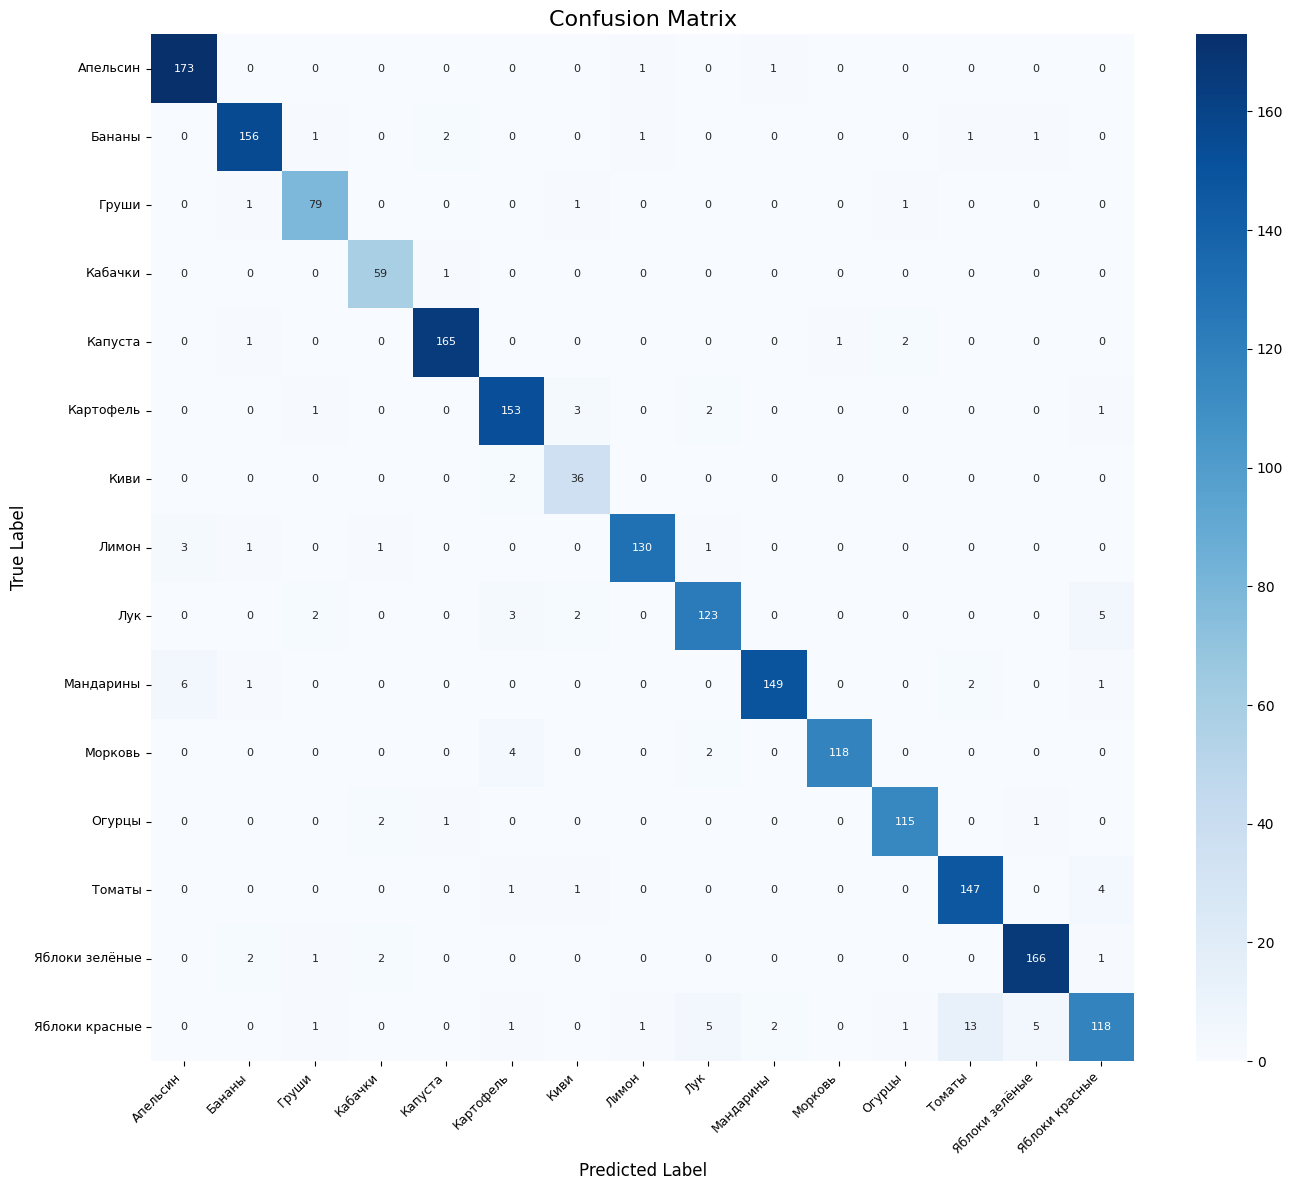


📊 ОБЩАЯ СТАТИСТИКА:
Всего образцов: 1991
Правильных предсказаний: 1887
Ошибок: 104
Точность: 0.9478

🔍 ТОП-10 САМЫХ ЧАСТЫХ ОШИБОК:
Яблоки красные → Томаты: 13 ошибок
Мандарины → Апельсин: 6 ошибок
Яблоки красные → Яблоки зелёные: 5 ошибок
Яблоки красные → Лук: 5 ошибок
Лук → Яблоки красные: 5 ошибок
Томаты → Яблоки красные: 4 ошибок
Морковь → Картофель: 4 ошибок
Лук → Картофель: 3 ошибок
Лимон → Апельсин: 3 ошибок
Картофель → Киви: 3 ошибок

📈 МЕТРИКИ ПО КЛАССАМ:
🟢 Апельсин        | F1: 0.9692 | Precision: 0.9505 | Recall: 0.9886 | Support: 175.0
🟢 Бананы          | F1: 0.9630 | Precision: 0.9630 | Recall: 0.9630 | Support: 162.0
🟢 Груши           | F1: 0.9461 | Precision: 0.9294 | Recall: 0.9634 | Support: 82.0
🟢 Кабачки         | F1: 0.9516 | Precision: 0.9219 | Recall: 0.9833 | Support: 60.0
🟢 Капуста         | F1: 0.9763 | Precision: 0.9763 | Recall: 0.9763 | Support: 169.0
🟢 Картофель       | F1: 0.9444 | Precision: 0.9329 | Recall: 0.9563 | Support: 160.0
🔴 Киви            | F1:

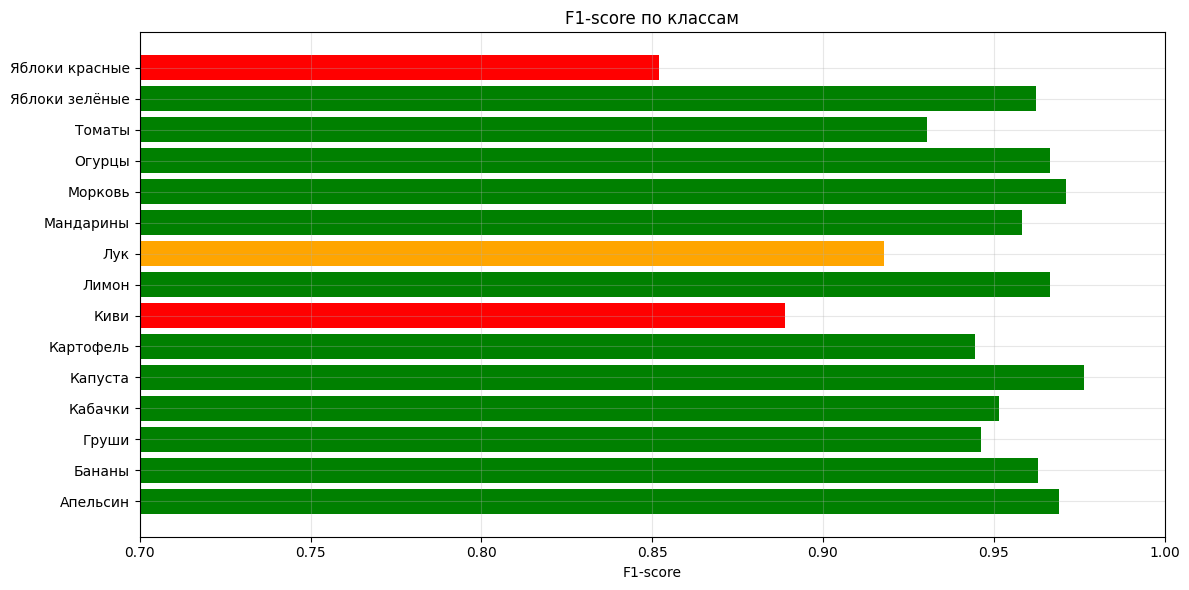


💡 РЕКОМЕНДАЦИИ:
Обратите внимание на классы: Киви, Лук, Яблоки красные

Киви путается с:
  → Картофель: 2 раз

Лук путается с:
  → Яблоки красные: 5 раз
  → Картофель: 3 раз
  → Киви: 2 раз

Яблоки красные путается с:
  → Томаты: 13 раз
  → Яблоки зелёные: 5 раз
  → Лук: 5 раз


In [52]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


cm = confusion_matrix(all_test_labels, ensemble_preds)


plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues',
            annot_kws={'size': 8})
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()


total_errors = len(all_test_labels) - np.trace(cm)

print(f"Всего образцов: {len(all_test_labels)}")
print(f"Правильных предсказаний: {np.trace(cm)}")
print(f"Ошибок: {total_errors}")
print(f"Точность: {np.trace(cm)/len(all_test_labels):.4f}")



errors = []
for i in range(15):
    for j in range(15):
        if i != j and cm[i][j] > 0:
            errors.append((cm[i][j], i, j))


errors.sort(reverse=True)

for count, i, j in errors[:10]:  # топ-10
    print(f"{class_names[i]} → {class_names[j]}: {count} ошибок")



report = classification_report(all_test_labels, ensemble_preds,
                              target_names=class_names,
                              digits=4,
                              output_dict=True)

for class_name in class_names:
    precision = report[class_name]['precision']
    recall = report[class_name]['recall']
    f1 = report[class_name]['f1-score']
    support = report[class_name]['support']

    # Подсвечиваем проблемные классы
    if f1 < 0.90:
        marker = "🔴"
    elif f1 < 0.93:
        marker = "🟡"
    else:
        marker = "🟢"

    print(f"{marker} {class_name:15} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | Support: {support}")


plt.figure(figsize=(12, 6))
f1_scores = [report[class_name]['f1-score'] for class_name in class_names]
colors = ['red' if f1 < 0.9 else 'orange' if f1 < 0.93 else 'green' for f1 in f1_scores]

plt.barh(class_names, f1_scores, color=colors)
plt.xlabel('F1-score')
plt.title('F1-score по классам')
plt.xlim(0.7, 1.0)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


problematic_classes = []
for i, class_name in enumerate(class_names):
    if f1_scores[i] < 0.93:
        problematic_classes.append(class_name)

if problematic_classes:
    print(f"Обратите внимание на классы: {', '.join(problematic_classes)}")


    for class_name in problematic_classes:
        class_idx = class_to_idx[class_name]
        print(f"\n{class_name} путается с:")
        confusions = []
        for j in range(15):
            if j != class_idx and cm[class_idx][j] > 0:
                confusions.append((cm[class_idx][j], class_names[j]))
        confusions.sort(reverse=True)
        for count, other_class in confusions[:3]:
            print(f"  → {other_class}: {count} раз")
else:
    print(" Все классы показывают хорошие результаты!")